# Did you perceive the tinnitus right now? 
## Analysis grouped by country and continent

In [28]:
# project location
p_loc = 'C:/Users/joa24jm/Documents/tinnitus-country/'

# add src to path so the noteboook can import utilities.py
import sys
sys.path.append('C:\\Users\\joa24jm\\Documents\\tinnitus-country\\src\\')

In [29]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from d00_utils import utilities as u

In [30]:
# read in intermediate dataframe merged_users
df = pd.read_csv(p_loc + 'data/02_intermediate/merged_users.csv', index_col = 'Unnamed: 0')

In [31]:
df.shape

(97742, 65)

In [32]:
# replace column names and values for better readability
df.rename(columns = {'question1': 'Tinnitus_right_now'}, inplace = True)
df.Tinnitus_right_now.replace({0.0:'No', 1.0:'Yes'}, inplace = True)

In [33]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(df.Continent_Name, df.Tinnitus_right_now)
ct

Tinnitus_right_now,No,Yes
Continent_Name,,
Africa,105,371
Antarctica,2,0
Asia,638,2676
Europe,17462,58748
North America,1816,10505
Oceania,155,1526
South America,241,1180


In [34]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})
stacked.Continent_Name.replace({'North America':'North\nAmerica', 'South America':'South\nAmerica'}, inplace = True)

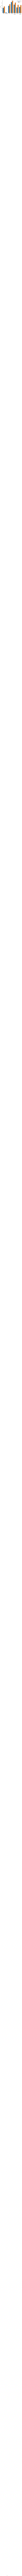

In [35]:
# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(x= stacked.Continent_Name, y = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax)

# set log scale and labels
ax.set_yscale('log')
ax.set_xlabel('')
ax.set_ylabel('Count')

# show values on bars
u.show_values_on_bars(ax, h_v = 'v', space = 1)


## Plot tinnitus_right_now per country on a horizontal barplot
Define two tresholds for `n_questionnaires > 300` and `n_users > 30`

In [36]:
# get all countries with more than 30 users
u_treshold = 30

s = df.groupby('Country_Name').nunique()['user_id'] > u_treshold
u_countries = s[s].index.tolist()

# from these countries, get all with more than 300 answers
s = df[df.Country_Name.isin(u_countries)].groupby('Country_Name').size() > 300
countries = s[s].index.tolist()

In [37]:
# generate a sub dataframe with these countries
sub_df = df[df.Country_Name.isin(countries)]

In [14]:
# generate a crosstab and save it as 'ct'
ct = pd.crosstab(sub_df.Country_Name, sub_df.Tinnitus_right_now, normalize = False)

ct

Tinnitus_right_now,No,Yes
Country_Name,,
"Australia, Commonwealth of",95,558
"Austria, Republic of",386,920
"Belgium, Kingdom of",276,688
"Brazil, Federative Republic of",29,305
Canada,322,1989
"France, French Republic",75,378
"Germany, Federal Republic of",10789,40495
"Italy, Italian Republic",53,1147
"Netherlands, Kingdom of the",2388,4833


In [15]:
# add information about the n_users and the n_questionnaires
# same dataframe with normalized indices
ct2 = pd.crosstab(sub_df.Country_Name, sub_df.Tinnitus_right_now, normalize = 'index')
ct2['n_questionnaires'] = sub_df.groupby('Country_Name').size()
ct2['n_users'] = sub_df.groupby('Country_Name').nunique()['user_id']
ct2

Tinnitus_right_now,No,Yes,n_questionnaires,n_users
Country_Name,,,,
"Australia, Commonwealth of",0.145482,0.854518,666,77
"Austria, Republic of",0.295559,0.704441,1321,68
"Belgium, Kingdom of",0.286307,0.713693,972,44
"Brazil, Federative Republic of",0.086826,0.913174,344,50
Canada,0.139334,0.860666,2341,126
"France, French Republic",0.165563,0.834437,467,72
"Germany, Federal Republic of",0.210378,0.789622,51804,1410
"Italy, Italian Republic",0.044167,0.955833,1220,81
"Netherlands, Kingdom of the",0.330702,0.669298,7268,180


In [27]:
# statistics to report about this subset
ct2.describe()

Tinnitus_right_now,No,Yes,n_questionnaires,n_users
count,15.000000,15.000000,15.000000,15.000000
mean,0.210274,0.789726,5869.933333,210.866667
std,0.122129,0.122129,13058.494343,356.548507
min,0.044167,0.486649,344.000000,38.000000
25%,0.133652,0.709067,591.500000,59.000000
50%,0.181564,0.818436,1220.000000,81.000000
75%,0.290933,0.866348,4426.000000,153.000000
max,0.513351,0.955833,51804.000000,1410.000000


In [22]:
# safe ct2 to .csv excel
# ct2.to_csv(p_loc + 'results/01_tables/tinnitus_by_country.csv')

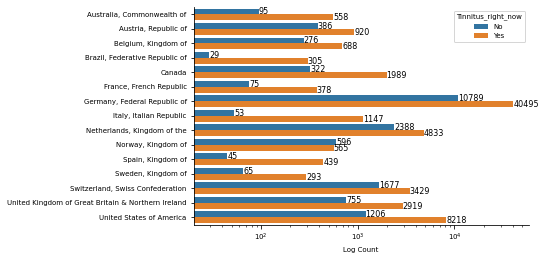

In [16]:
# stack results and rename for better readability
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xscale('log')
ax.set_xlabel('Log Count')
ax.set_ylabel('')

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]


In [17]:
ct2.columns

Index(['No', 'Yes', 'n_questionnaires', 'n_users'], dtype='object', name='Tinnitus_right_now')

In [18]:
# stack results and rename for better readability
stacked = ct2[['No', 'Yes']].stack().reset_index().rename(columns={0:'value'})

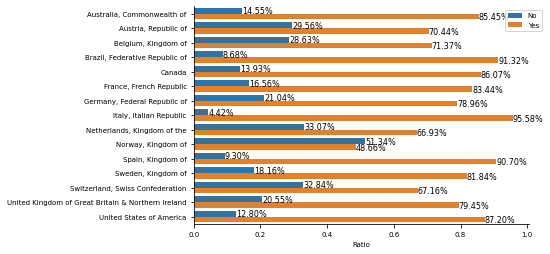

In [19]:
# decrease font size
matplotlib.rcParams.update({'font.size': 7})

# create plot and add annotations
fig, ax = plt.subplots(1,1)

# remove top and right frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

sns.barplot(y= stacked.Country_Name, x = stacked.value, hue = stacked.Tinnitus_right_now, ax = ax,
            orient = 'h')

# set log scale and labels
ax.set_xlabel('Ratio')
ax.set_ylabel('')

ax.legend(bbox_to_anchor=(1.05,1))

# show values on bars
u.show_values_on_bars(ax, h_v = 'h', space = 0.4, normalize = True)

# safe ylabels as reference for normalized bar plot
ylabels = [label.get_text() for label in ax.get_yticklabels()]